In [14]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [15]:
import numpy as np
import pandas as pd

In [16]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [17]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [18]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [19]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [20]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [21]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [22]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

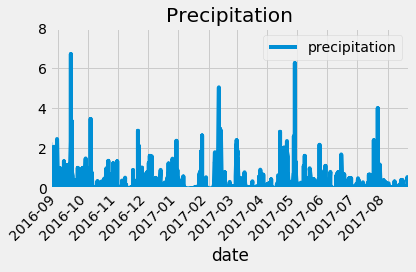

In [24]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

max_date = session.query(
    func.max(Measurement.date)
).first()
max_date = [r for r in max_date]
last_date = dt.datetime.strptime(max_date[0], '%Y-%m-%d')

# Calculate the date 1 year ago from the last data point in the database

prev_year = last_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores

query = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= prev_year).all()
query_list = [r for r in query]

# Save the query results as a Pandas DataFrame and set the index to the date column

climate_df = pd.DataFrame(query_list,columns=['date', 'precipitation'])
climate_df['date'] =pd.to_datetime(climate_df.date)
climate_df.set_index('date', inplace=True)

# Sort the dataframe by date

climate_df = climate_df.sort_values(by='date',ascending=False)

# Use Pandas Plotting with Matplotlib to plot the data

climate_df = climate_df.dropna()
climate_df.plot()
plt.xticks(rotation=45)
plt.ylim(0,8)
plt.title("Precipitation")
plt.legend(loc='upper right')
plt.tight_layout()

In [25]:
# Use Pandas to calcualte the summary statistics for the precipitation data
climate_df.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [35]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(func.count(Station.station)).all()
print(station_count)

[(9,)]


In [27]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
q = [r for r in session.query(
    Measurement.station,
        func.count(Measurement.station)
        ).group_by(Measurement.station
            ).order_by(func.count(Measurement.station).desc()).all()]
q

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [29]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
most_active_station = q[0][0]
[r for r in session.query(
                func.min(Measurement.tobs),
                func.max(Measurement.tobs),
                func.avg(Measurement.tobs)).filter(
                Measurement.station == most_active_station)]


[(54.0, 85.0, 71.66378066378067)]

USC00519281


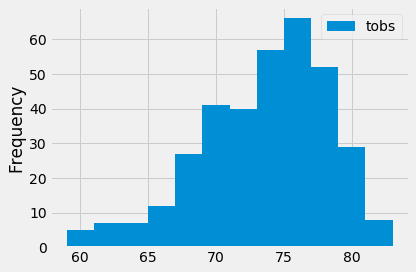

In [30]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
q = [r for r in session.query(
    Measurement.station,
        func.count(Measurement.tobs)
        ).group_by(Measurement.station
            ).order_by(func.count(Measurement.tobs).desc()).first()]
highest_tobs = q[0]
print(highest_tobs)

tobs_q = session.query(Measurement.tobs
                      ).filter(Measurement.date >= prev_year).filter(Measurement.station == highest_tobs).all()
tobs_df = pd.DataFrame(tobs_q)
tobs_df.head()
tobs_df.plot.hist(bins=12)

plt.legend(loc='best')
plt.tight_layout()

![precipitation](Images/station-histogram.png)

In [31]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [32]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start_date = dt.date(2017,9,1)
end_date = dt.date(2017,9,9)
prev_year_start_date = start_date - dt.timedelta(days=365)
prev_year_end_date = end_date - dt.timedelta(days=365)
tmin, tavg, tmax = calc_temps(prev_year_start_date, prev_year_end_date)[0]
print(tmin, tavg, tmax)

73.0 77.96363636363637 84.0


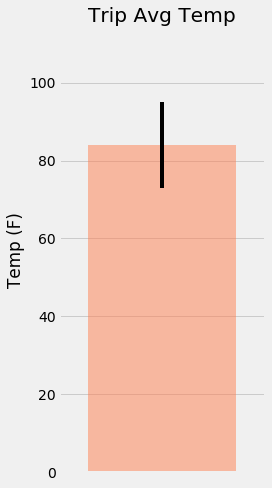

In [33]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
xpos = 1
yerr = tmax-tmin

plt.figure(figsize=(4,7))
plt.bar(xpos, tmax, yerr=yerr, alpha=0.5, width=0.1, color='coral', align="center")
plt.xticks(np.arange(1, 1.0))
plt.title("Trip Avg Temp")
plt.ylabel("Temp (F)")
plt.margins(0.2,0.2)
plt.tight_layout()

In [34]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
q = [r for r in session.query(
    Measurement.station,Station.name, 
    Station.latitude,
    Station.longitude, 
    Station.elevation,
        func.sum(Measurement.prcp)
        ).filter(Measurement.date >= prev_year_start_date
                ).filter(Measurement.date <= prev_year_end_date
                        ).group_by(Measurement.station
                                  ).order_by(func.sum(Measurement.prcp).desc()).all()]
q


[('USC00516128', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 40.59),
 ('USC00519523',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  10.979999999999999),
 ('USC00519281',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  7.3800000000000034),
 ('USC00514830',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  6.839999999999998),
 ('USC00513117',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  5.4899999999999975),
 ('USC00519397',
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0,
  0.9900000000000004),
 ('USC00517948', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, None)]